In [1]:
import numpy as np
import pandas as pd
import multiprocessing as mp
from inspect import signature
from matplotlib import pyplot as plt
from dacbench.logger import Logger, log2dataframe, load_logs
import seaborn as sns
import glob
from plotting import _plot_performance_over_time, plot_performance_over_time, plot_final_performance_comparison, plot_improvement_probability, plot_configuration_footprint, plot_hp_importance, plot_deepcave
#from plotting import plot_performance_over_time, plot_final_performance_comparison, plot_improvement_probability, plot_configuration_footprint, plot_hp_importance, plot_deepcave

/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/dacbench/envs/__init__.py:35: UserWarning: CMA-ES Benchmark not installed. If you want to use this benchmark, please follow the installation guide.
  warnings.warn(  # noqa: B028
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/dacbench/benchmarks/__init__.py:26: UserWarning: CMA-ES Benchmark not installed. If you want to use this benchmark, please follow the installation guide.
  warnings.warn(  # noqa: B028


DACBench Gym registration failed - make sure you have all dependencies installed and their instance sets in the right path!


In [4]:
def toDataFrame(glob_path, col_name, col_index, method=None, dataset=None):
    d =  [log2dataframe(load_logs(path)) for path in glob.glob(glob_path)]
    
    df = pd.DataFrame([s[col_name][col_index] for s in d]).transpose()
    df['epoch'] = df.index + 1
    df = df.melt(id_vars=['epoch'])
    df.rename(columns={'variable': 'seed'}, inplace=True)
    
    if method:
        df['method'] = method

    if dataset:
        df['dataset'] = dataset

    return df

def toChunkedDataFrame(glob_path, col_name, col_index, chunk_size):
    d =  [log2dataframe(load_logs(path)) for path in glob.glob(glob_path)]

    df = pd.DataFrame([s[col_name][col_index] for s in d]).transpose()

    result_df = pd.DataFrame()
    for col in df.columns:
        reshaped_data = df[col].values.reshape(-1, chunk_size)
        result_df[col] = reshaped_data.mean(axis=1)

    result_df.reset_index()

    result_df['epoch'] = result_df.index + 1
    result_df = result_df.melt(id_vars=['epoch'])

    return result_df


sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_style('whitegrid')
palette = sns.color_palette("colorblind")
palette = sns.color_palette([palette[0], palette[8], palette[6], palette[9], palette[7]])
sns.set_palette(palette)

       epoch seed     value method dataset
0          1    0  6.889646   Adam    aloi
1          2    0  6.865548   Adam    aloi
2          3    0  6.865797   Adam    aloi
3          4    0  6.825989   Adam    aloi
4          5    0  6.806219   Adam    aloi
...      ...  ...       ...    ...     ...
44995     96    9  0.746969   DoWG    wine
44996     97    9  0.796110   DoWG    wine
44997     98    9  0.788890   DoWG    wine
44998     99    9  0.904137   DoWG    wine
44999    100    9  0.800735   DoWG    wine

[45000 rows x 5 columns]


/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

<Figure size 1200x1200 with 0 Axes>

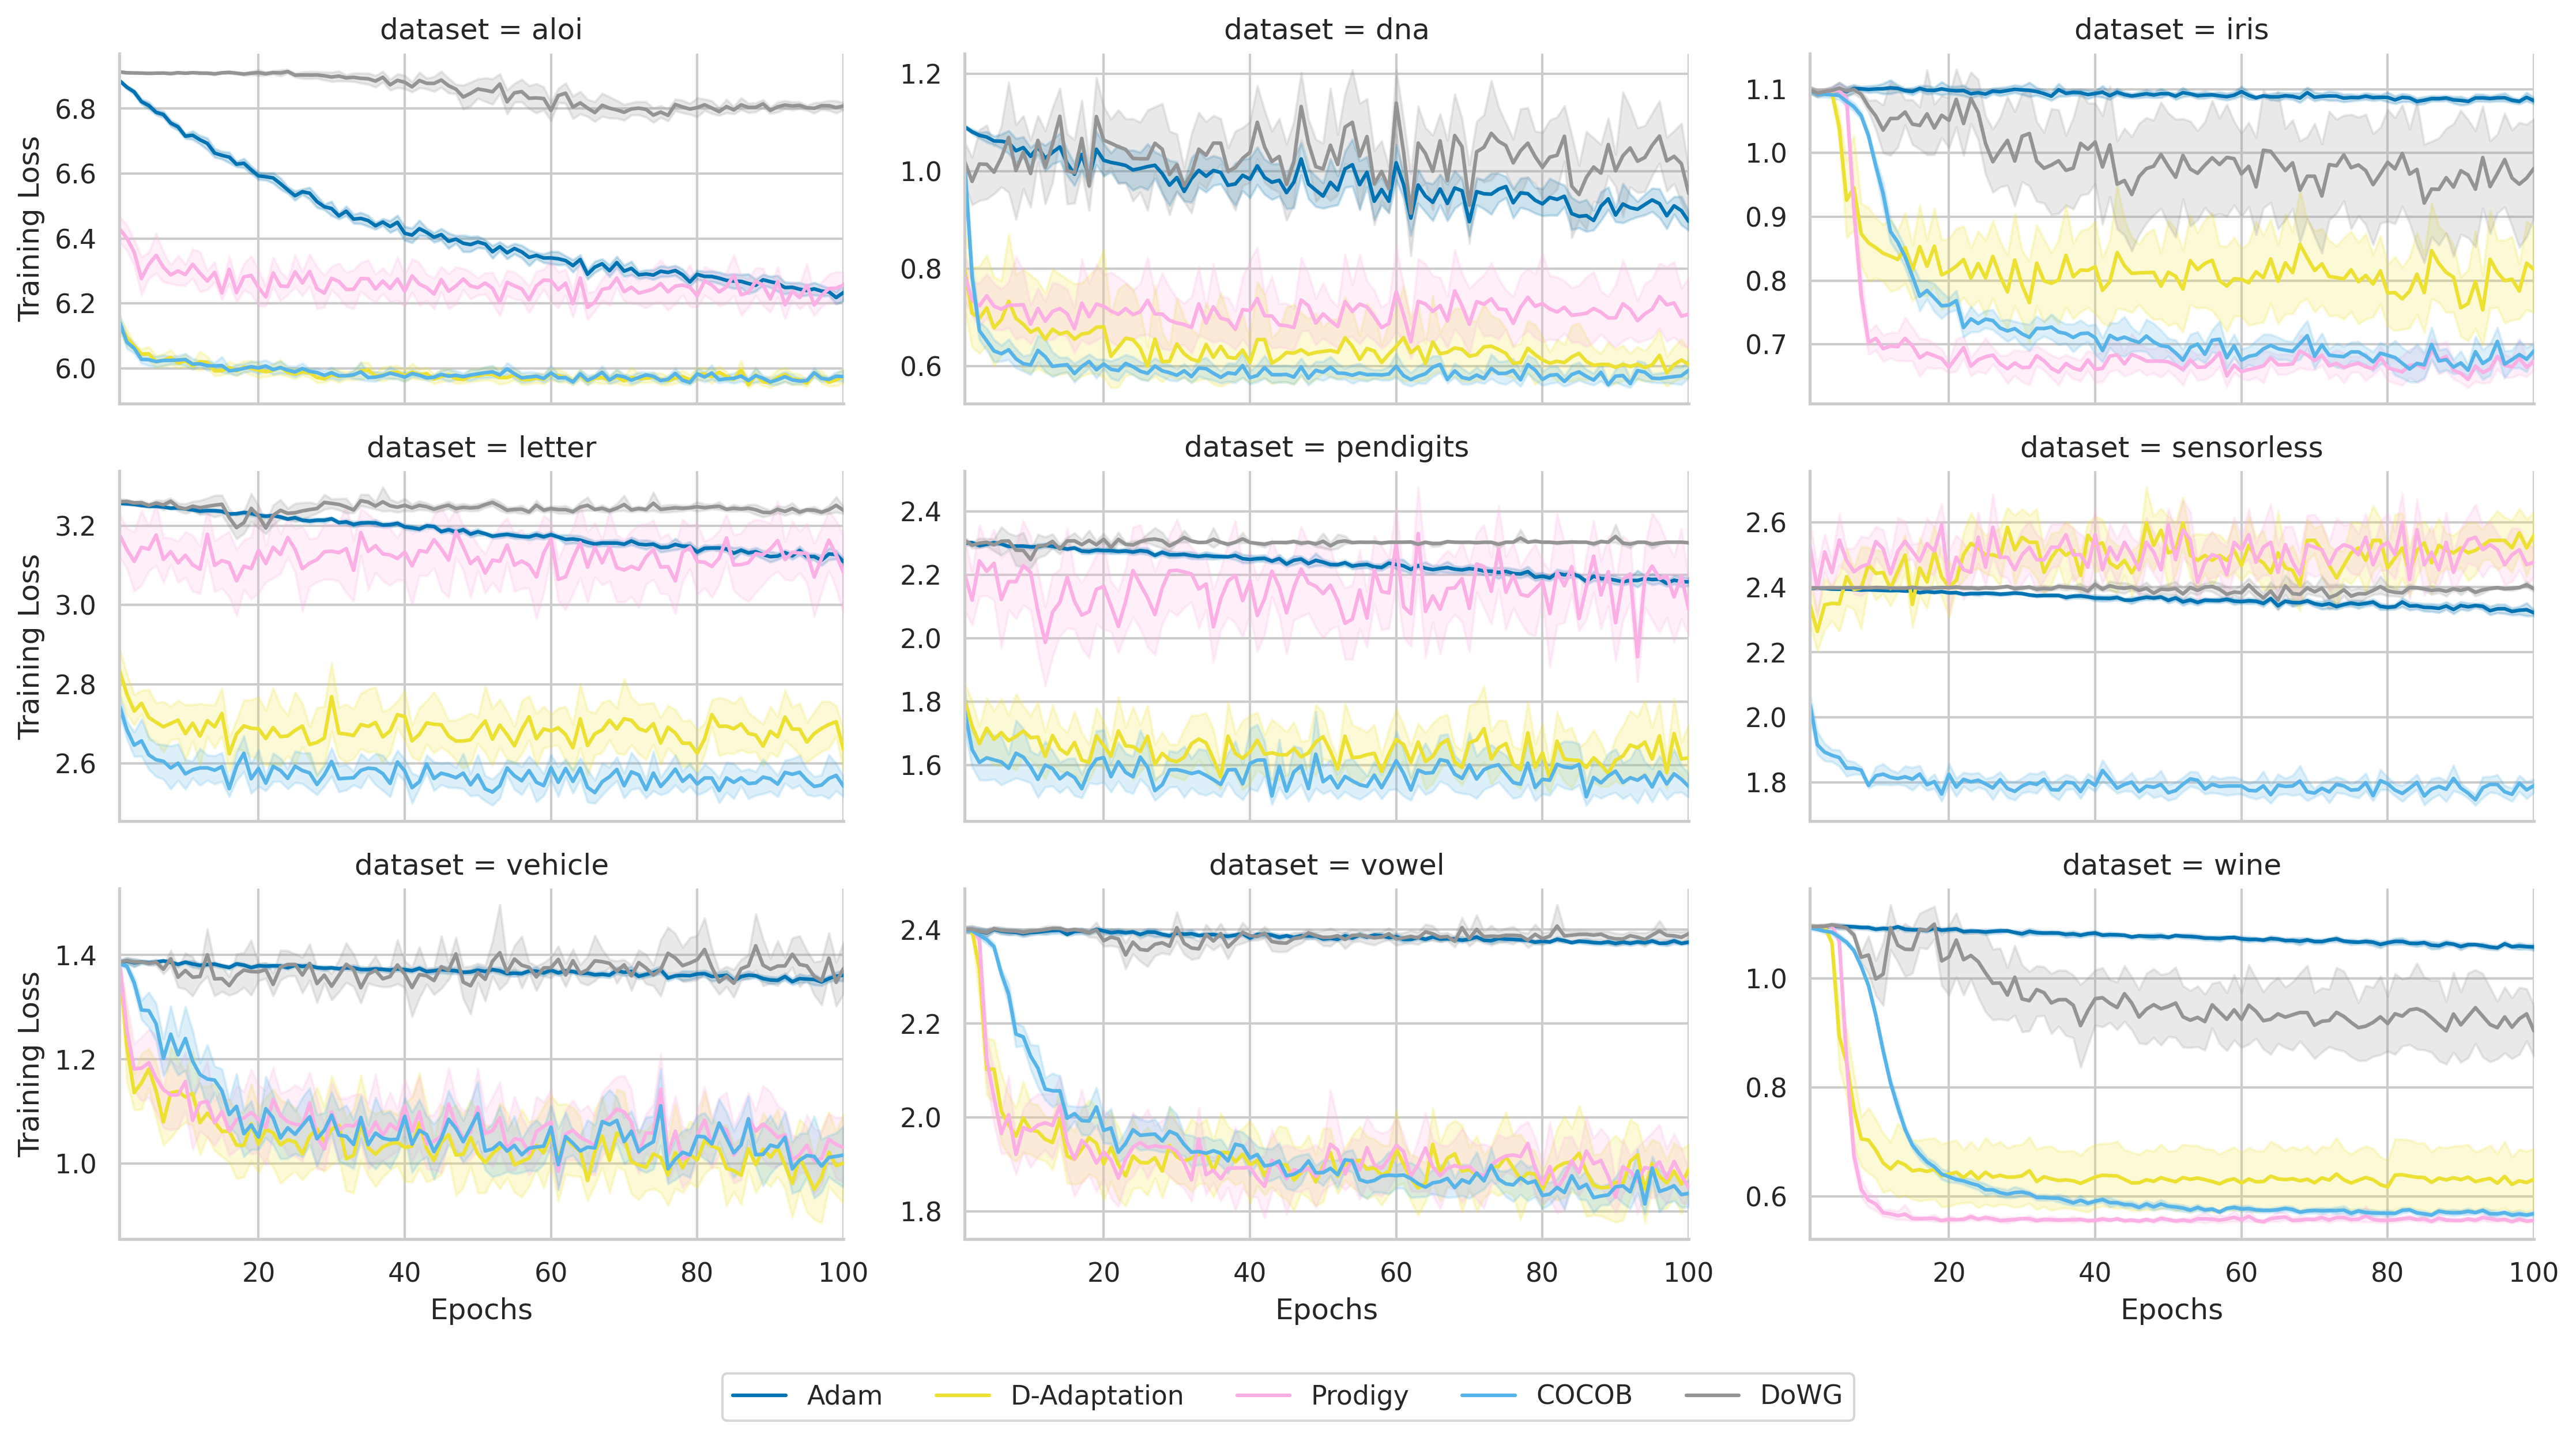

In [5]:

datasets = ['aloi', 'dna', 'iris', 'letter', 'pendigits', 'sensorless', 'vehicle', 'vowel', 'wine']

cocob_tl = pd.concat([toDataFrame('../results_cluster/results/COCOB_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='COCOB', dataset=dataset) for dataset in datasets], ignore_index=True)
dadaptation_tl = pd.concat([toDataFrame('../results_cluster/results/dadaptation_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='D-Adaptation', dataset=dataset) for dataset in datasets], ignore_index=True)
prodigy_tl = pd.concat([toDataFrame('../results_cluster/results/prodigy_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='Prodigy', dataset=dataset) for dataset in datasets], ignore_index=True)
adam_fixed_tl = pd.concat([toDataFrame('../results_cluster/results/Adam_fixed_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='Adam', dataset=dataset) for dataset in datasets], ignore_index=True)
dowg_tl = pd.concat([toDataFrame('../results_cluster/results/DoWG_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='DoWG', dataset=dataset) for dataset in datasets], ignore_index=True)
# 

# 'seed', 'epoch', 'method', 'training_loss' 'dataset'

df = pd.concat([adam_fixed_tl, dadaptation_tl, prodigy_tl, cocob_tl, dowg_tl], ignore_index=True)
print(df)
g = _plot_performance_over_time(
        data=df,
        x="epoch",
        y="value",
        xlabel="Epochs",
        ylabel="Training Loss",
        aggregation="mean",
        hue="method",
        col="dataset",
        col_wrap=3,
        sharey=False,
        aspect=1.5
    )

# Remove the legends from each facet.
for ax in g.axes.flat:
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

# Now, get handles and labels from one of the facets.
handles, labels = g.axes.flat[0].get_legend_handles_labels()
g._legend.remove()
# Add a global legend to the entire figure below the plots.
g.fig.legend(handles, labels,
             loc="lower center",
             bbox_to_anchor=(0.5, 0.05),  # adjust as needed
             ncol=len(labels),             # one column per label
             title=None,
             frameon=True)

# Optionally, remove facet titles if you don't need them.
g.fig.suptitle("")

# Adjust layout to make space for the legend.
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

      epoch seed     value method dataset
0         1    0  0.123521  COCOB    aloi
1         2    0  0.132674  COCOB    aloi
2         3    0  0.141272  COCOB    aloi
3         4    0  0.153199  COCOB    aloi
4         5    0  0.160133  COCOB    aloi
...     ...  ...       ...    ...     ...
8995     96    9  0.988125  COCOB    wine
8996     97    9  0.984375  COCOB    wine
8997     98    9  1.000000  COCOB    wine
8998     99    9  0.988125  COCOB    wine
8999    100    9  0.989583  COCOB    wine

[9000 rows x 5 columns]


/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

<Figure size 1200x1200 with 0 Axes>

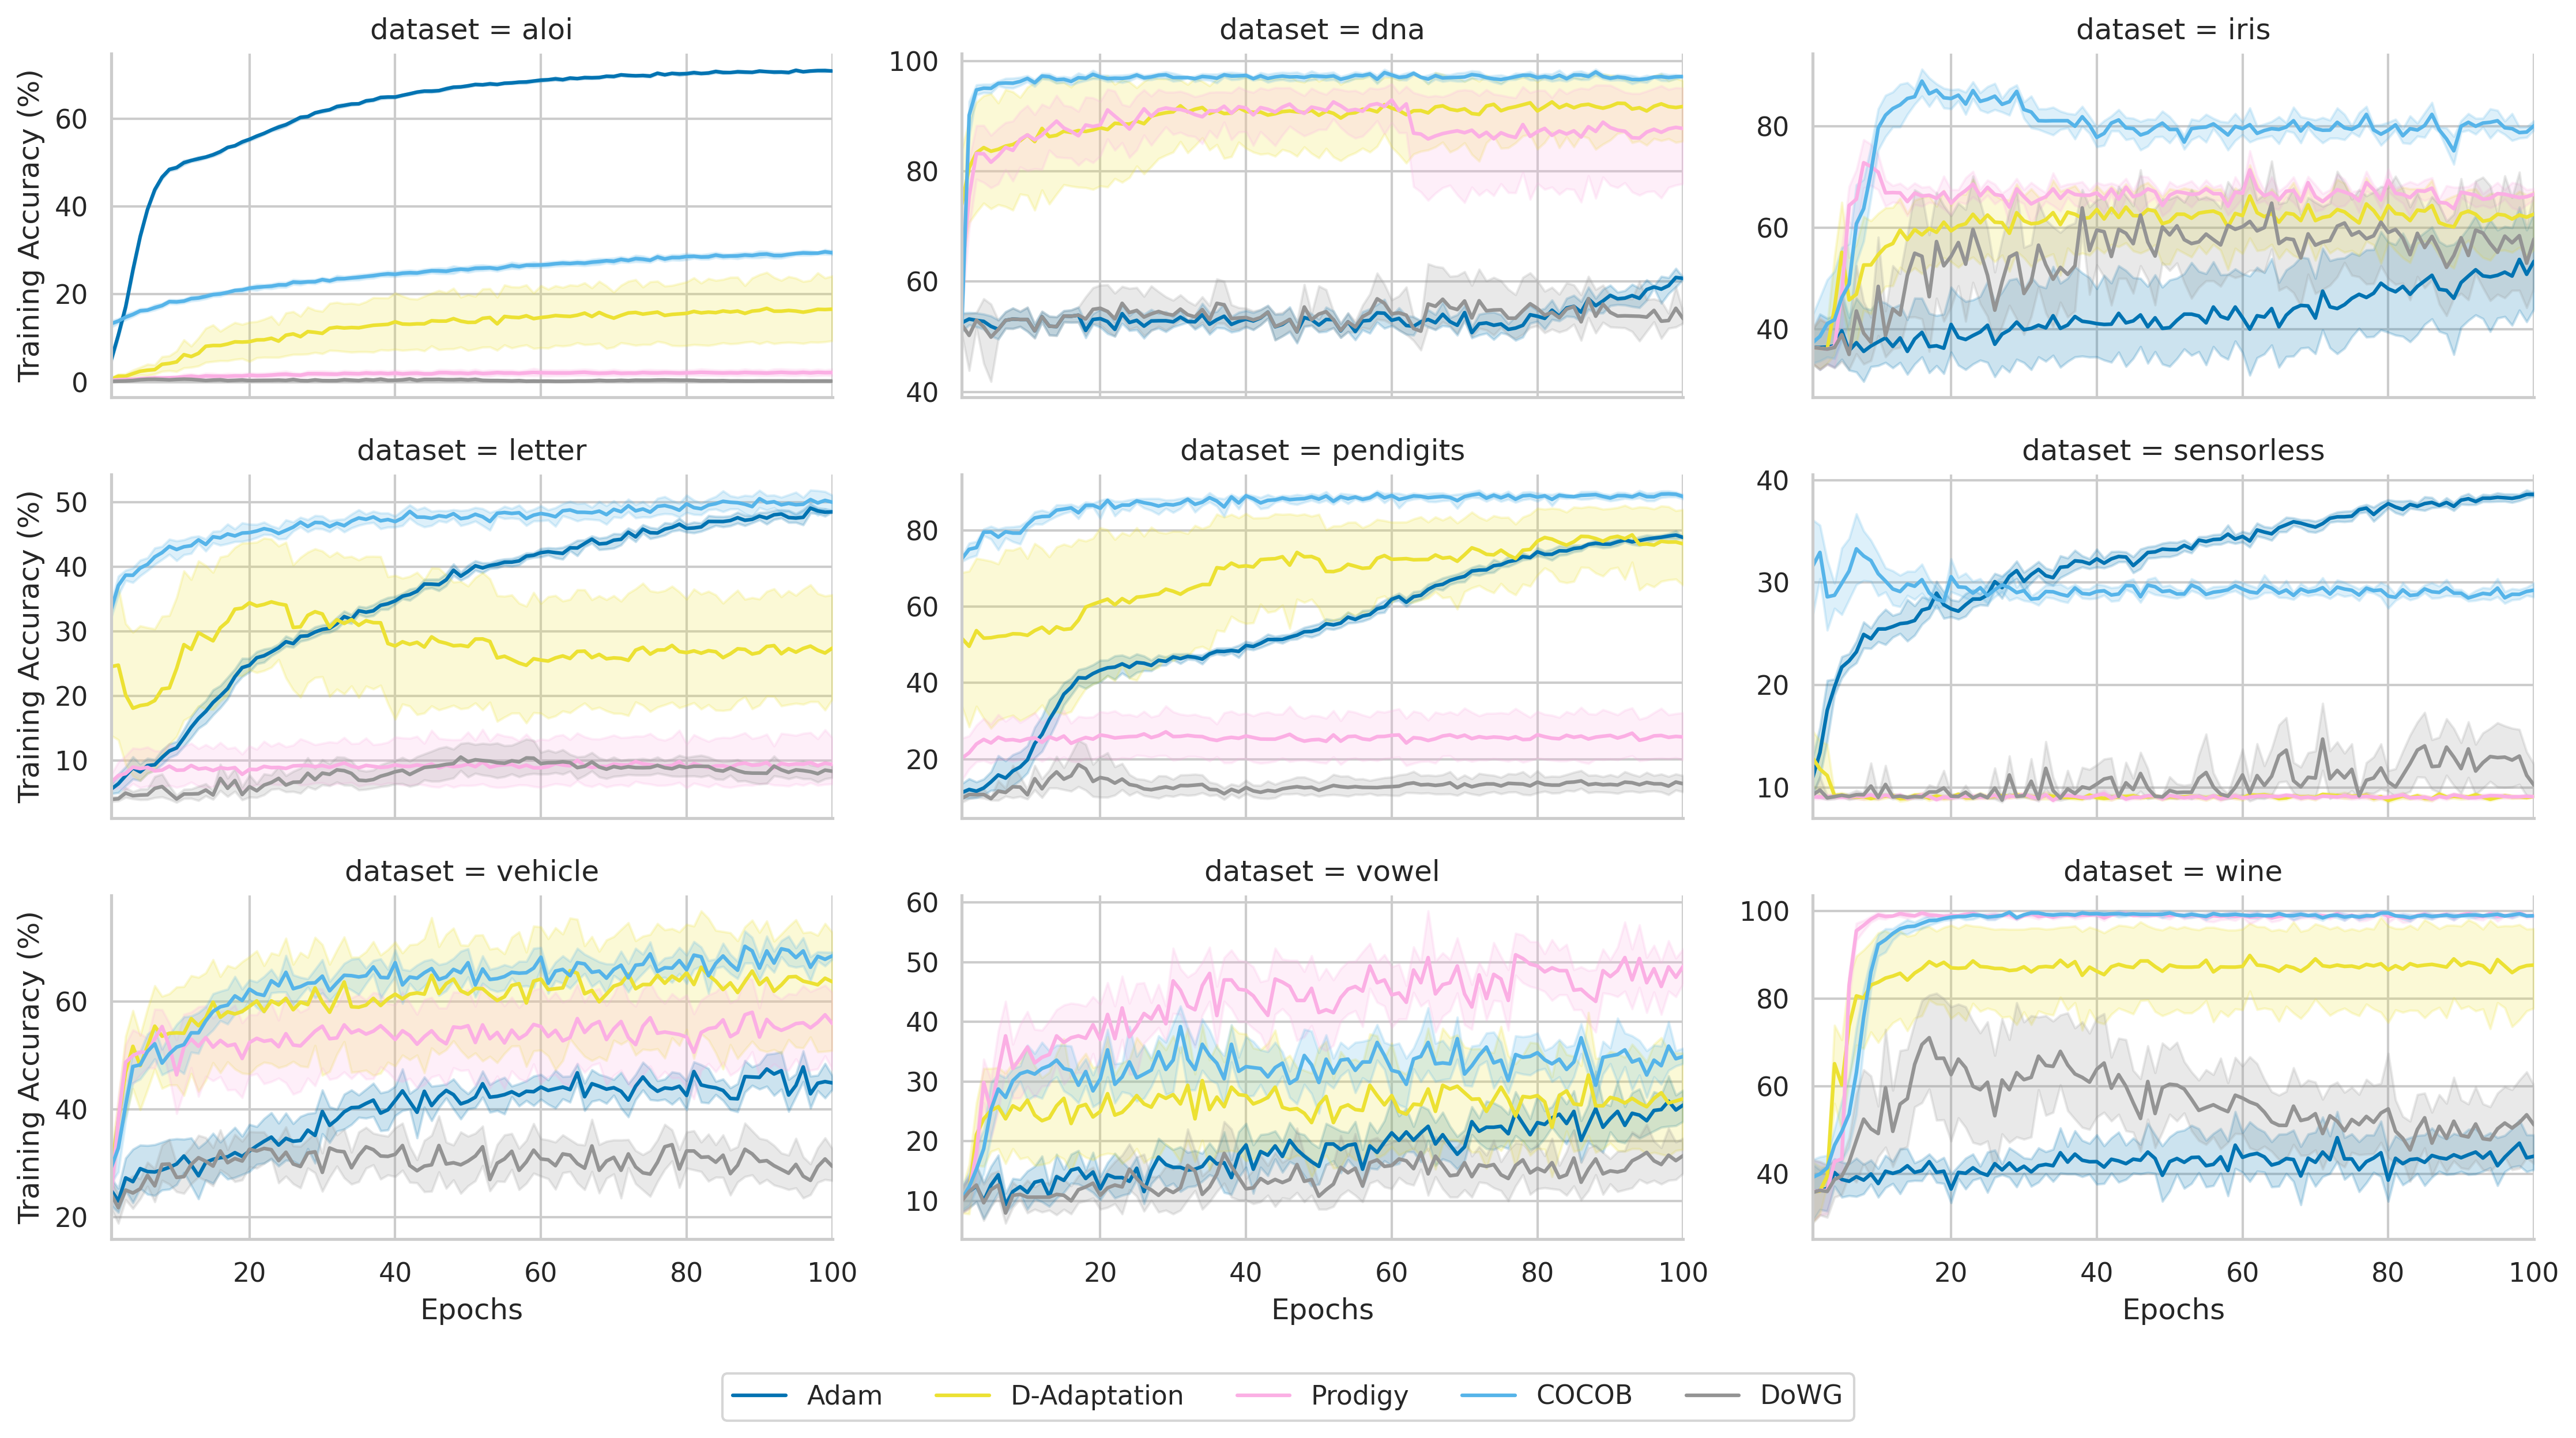

In [6]:

datasets = ['aloi', 'dna', 'iris', 'letter', 'pendigits', 'sensorless', 'vehicle', 'vowel', 'wine']

cocob_tl = pd.concat([toDataFrame('../results_cluster/results/COCOB_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='COCOB', dataset=dataset) for dataset in datasets], ignore_index=True)
dadaptation_tl = pd.concat([toDataFrame('../results_cluster/results/dadaptation_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='D-Adaptation', dataset=dataset) for dataset in datasets], ignore_index=True)
prodigy_tl = pd.concat([toDataFrame('../results_cluster/results/prodigy_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='Prodigy', dataset=dataset) for dataset in datasets], ignore_index=True)
adam_fixed_tl = pd.concat([toDataFrame('../results_cluster/results/Adam_fixed_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='Adam', dataset=dataset) for dataset in datasets], ignore_index=True)
dowg_tl = pd.concat([toDataFrame('../results_cluster/results/DoWG_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='DoWG', dataset=dataset) for dataset in datasets], ignore_index=True)


# 'seed', 'epoch', 'method', 'training_loss' 'dataset'
print(cocob_tl)
df = pd.concat([adam_fixed_tl, dadaptation_tl, prodigy_tl, cocob_tl, dowg_tl], ignore_index=True)
df['value'] = df['value'] * 100 # convert to percent

g = _plot_performance_over_time(
        data=df,
        x="epoch",
        y="value",
        xlabel="Epochs",
        ylabel="Training Accuracy (%)",
        aggregation="mean",
        hue="method",
        col="dataset",
        col_wrap=3,
        sharey=False,
        aspect=1.5
    )

# Remove the legends from each facet.
for ax in g.axes.flat:
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

# Now, get handles and labels from one of the facets.
handles, labels = g.axes.flat[0].get_legend_handles_labels()
g._legend.remove()
# Add a global legend to the entire figure below the plots.
g.fig.legend(handles, labels,
             loc="lower center",
             bbox_to_anchor=(0.5, 0.05),  # adjust as needed
             ncol=len(labels),             # one column per label
             title=None,
             frameon=True)

# Optionally, remove facet titles if you don't need them.
g.fig.suptitle("")

# Adjust layout to make space for the legend.
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

      epoch seed     value        method dataset
0         1    0  1.747910  D-Adaptation    aloi
1         2    0  1.747910  D-Adaptation    aloi
2         3    0  1.747910  D-Adaptation    aloi
3         4    0  1.747910  D-Adaptation    aloi
4         5    0  1.747910  D-Adaptation    aloi
...     ...  ...       ...           ...     ...
8995     96    9  4.516987  D-Adaptation    wine
8996     97    9  4.516987  D-Adaptation    wine
8997     98    9  4.516987  D-Adaptation    wine
8998     99    9  4.516987  D-Adaptation    wine
8999    100    9  4.516987  D-Adaptation    wine

[9000 rows x 5 columns]
      epoch seed        value     method dataset
0         1    0  1243.115845  D-AdaptLR    aloi
1         2    0  2754.218262  D-AdaptLR    aloi
2         3    0  3960.974121  D-AdaptLR    aloi
3         4    0  2220.620361  D-AdaptLR    aloi
4         5    0  2580.969238  D-AdaptLR    aloi
...     ...  ...          ...        ...     ...
8995     96    9    49.621910  D-AdaptLR    

/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

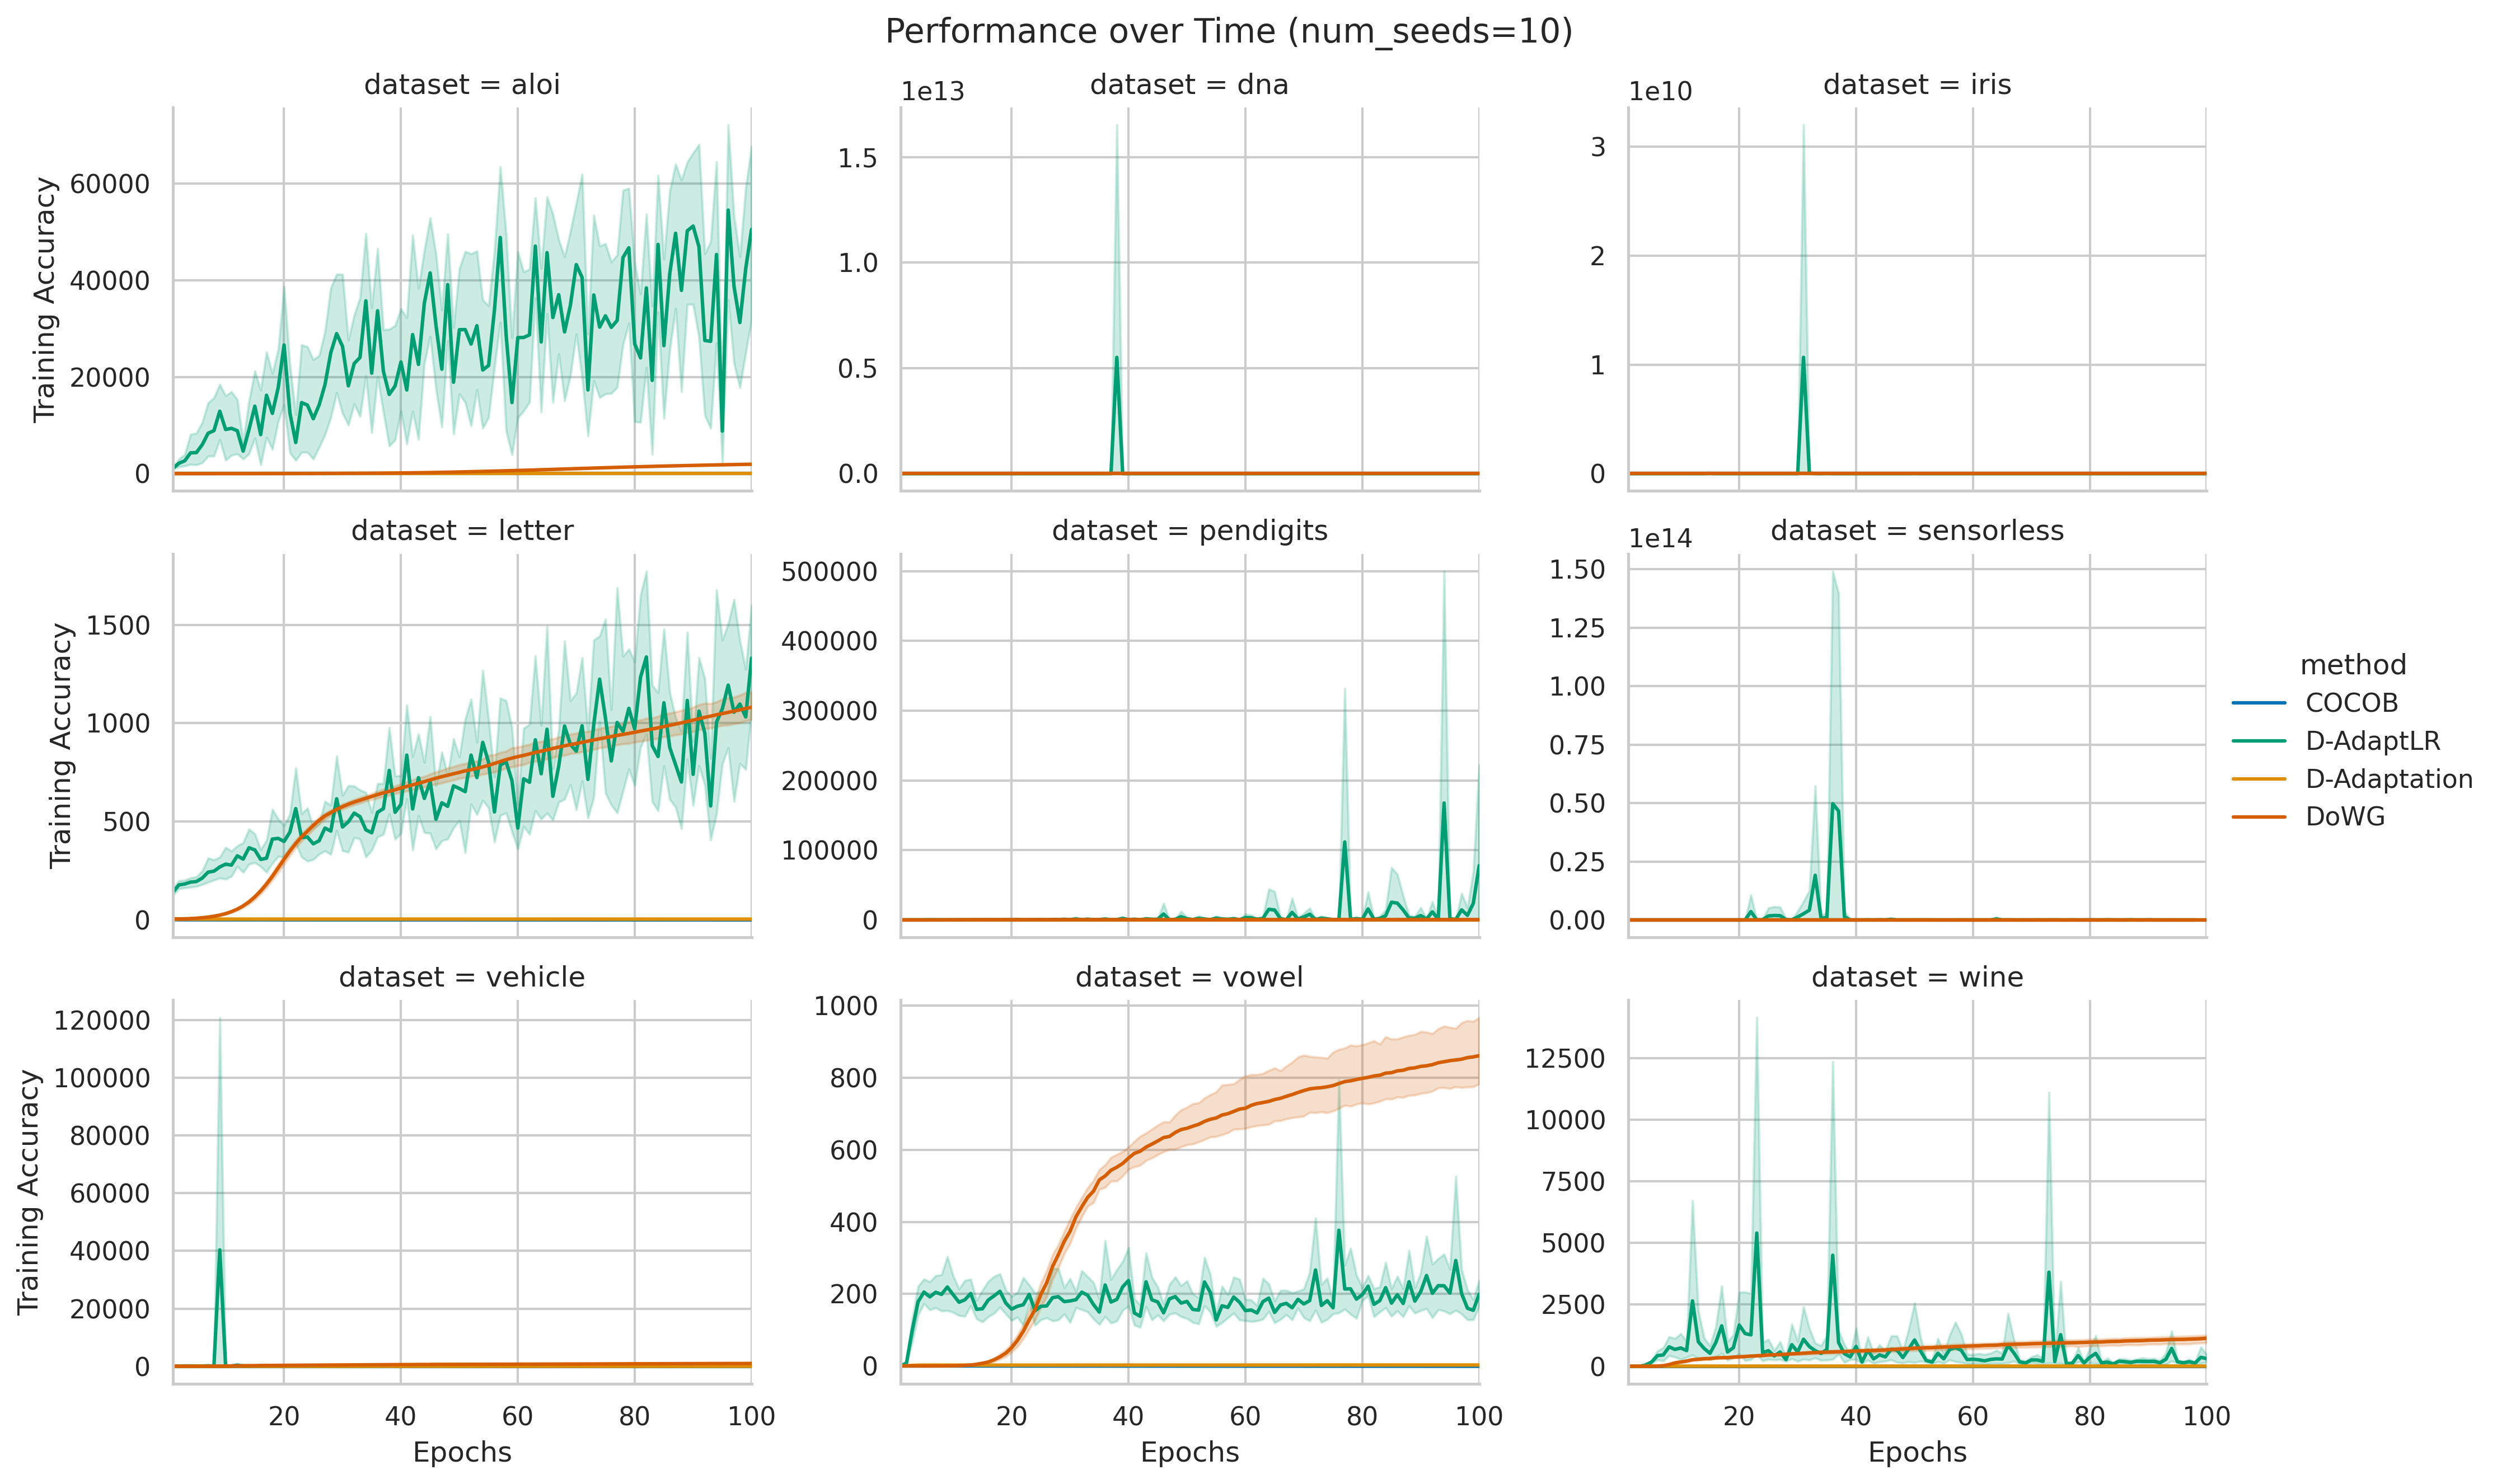

In [8]:

datasets = ['aloi', 'dna', 'iris', 'letter', 'pendigits', 'sensorless', 'vehicle', 'vowel', 'wine']

cocob_tl = pd.concat([toDataFrame('../results_cluster/results/COCOB_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'effective_lrs', 9, method='COCOB', dataset=dataset) for dataset in datasets], ignore_index=True)
dadaptation_tl = pd.concat([toDataFrame('../results_cluster/results/dadaptation_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'dlrs', 10, method='D-Adaptation', dataset=dataset) for dataset in datasets], ignore_index=True)
dadaptation_tl_2 = pd.concat([toDataFrame('../results_cluster/results/dadaptation_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'effective_lrs', 9, method='D-AdaptLR', dataset=dataset) for dataset in datasets], ignore_index=True)
prodigy_tl = pd.concat([toDataFrame('../results_cluster/results/prodigy_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'effective_lrs', 9, method='Prodigy', dataset=dataset) for dataset in datasets], ignore_index=True)
# adam_fixed_tl = pd.concat([toDataFrame('../results_cluster/results/Adam_fixed_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='Adam Fixed', dataset=dataset) for dataset in datasets], ignore_index=True)
dowg_tl = pd.concat([toDataFrame('../results_cluster/results/DoWG_libsvm/' + dataset + '/*/CustomTrackingWrapper.jsonl', 'effective_lrs', 9, method='DoWG', dataset=dataset) for dataset in datasets], ignore_index=True)


# 'seed', 'epoch', 'method', 'training_loss' 'dataset'
# print(dadaptation_tl[cocob_tl['dataset'] == 'iris'])
print(dadaptation_tl)
print(dadaptation_tl_2)
df = pd.concat([cocob_tl, dadaptation_tl_2, dadaptation_tl, dowg_tl], ignore_index=True)

_plot_performance_over_time(
        data=df,
        x="epoch",
        y="value",
        xlabel="Epochs",
        ylabel="Training Accuracy",
        aggregation="mean",
        hue="method",
        col="dataset",
        col_wrap=3,
        sharey=False,
        aspect=1.5
    )